In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import argparse
from google.colab import files
from torch.utils.data import Subset
from sklearn.manifold import TSNE
from resnet import *
import csv

In [ ]:
device = torch.device('cuda')

In [ ]:
class Augment_train(object):
  def __init__(self,size):
    s = 0.5 # jitter strength
    size = 32
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    
    self.train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.8), 
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
  
  def __call__(self,x):
    transform = self.train_transforms

    xi = transform(x)
    xj = transform(x)
    return xi, xj

In [ ]:
dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform= Augment_train(32))


Files already downloaded and verified


In [ ]:
#create a subset from training data

with open('datalabel.txt', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['current_class','label'])

def create_subset(ds):
  
  airplane_i, dog_i, deer_i, frog_i, cat_i, bird_i, horse_i, automobile_i, ship_i, truck_i = [], [], [], [], [],[],[],[],[],[]
  dog_idx, deer_idx, airplane_idx, frog_idx, cat_idx, bird_idx, automobile_idx, ship_idx, truck_idx, horse_idx = ds.class_to_idx['dog'], ds.class_to_idx['deer'],ds.class_to_idx['airplane'],ds.class_to_idx['frog'],ds.class_to_idx['cat'],ds.class_to_idx['bird'],ds.class_to_idx['automobile'],ds.class_to_idx['ship'],ds.class_to_idx['truck'],ds.class_to_idx['horse']
  label=[]
  for i in range(len(ds)):
    current_class = ds[i][1]
    if current_class == dog_idx:
      dog_i.append(i)
      label='dog'
    elif current_class == deer_idx:
      deer_i.append(i)
      label='deer'
    elif current_class == airplane_idx:
      airplane_i.append(i)
      label='airplane'
    elif current_class == frog_idx:
      frog_i.append(i)
      label='frog'
    elif current_class == cat_idx:
      cat_i.append(i)
      label='cat'
    elif current_class == bird_idx:
      bird_i.append(i)
      label='bird'
    elif current_class == automobile_idx:
      automobile_i.append(i)
      label='automobile'
    elif current_class == ship_idx:
      ship_i.append(i)
      label='ship'
    elif current_class == truck_idx:
      truck_i.append(i) 
      label='truck'
    else:
      horse_i.append(i)
      label='horse'
    with open('datalabel.txt', 'a', newline='') as csvfile:
          writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
          writer.writerow([current_class, label])

  airplane_ui = airplane_i[:int(0.2 * len(airplane_i))]
  dog_ui = dog_i[:int(0.2 * len(dog_i))]
  deer_ui = deer_i[:int(0.2 * len(deer_i))]
  frog_ui = frog_i[:int(0.2 * len(frog_i))]
  cat_ui = cat_i[:int(0.2 * len(cat_i))]
  bird_ui = bird_i[:int(0.2 * len(bird_i))]
  horse_ui = horse_i[:int(0.2 * len(horse_i))]
  automobile_ui = automobile_i[:int(0.2 * len(automobile_i))]
  ship_ui = ship_i[:int(0.2 * len(ship_i))]
  truck_ui = truck_i[:int(0.2 * len(truck_i))]

  unlabelled_dataset = Subset(ds, airplane_ui+ dog_ui+ deer_ui+ frog_ui+ cat_ui+ bird_ui+ horse_ui+ automobile_ui+ ship_ui+ truck_ui)
  
  
  return unlabelled_dataset
# files.download('datalabel.txt')
unlabelled_dataset = create_subset(dataset)
print(len(unlabelled_dataset))

10000


In [ ]:
trainloader = torch.utils.data.DataLoader(
    unlabelled_dataset, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
class NTXent_L(nn.Module):
  def __init__(self,batch_size,temperature=0.5):
      super().__init__()
      self.batch_size=batch_size
      self.temperature = temperature
      
  def cosine_sim(self, output1,output2): #output1, output2 as 2 augmented versions of image;
    o_con= torch.cat([output1,output2], dim=0)
    return F.cosine_similarity(o_con.unsqueeze(1), o_con.unsqueeze(0), dim=2)

  def forward(self, z_i, z_j):
    batch_size= z_i.shape[0]

    sim_m = self.cosine_sim(z_i,z_j)

    sim_ij = torch.diag(sim_m,batch_size)
    sim_ji = torch.diag(sim_m, -batch_size)
   
    sim_con= torch.cat([sim_ij, sim_ji],dim=0)
    pos= torch.exp(sim_con/self.temperature)

    mask = (~torch.eye(batch_size *2 ,batch_size*2, dtype=bool)).float() # ~ normally the mask chooses the diagonal, with this it chooses the elements other than the diagonal which masks the similarity of the same images (the boolean parameter in the loss formula)
    neg= mask.to(device) *torch.exp(sim_m/self.temperature)
    
    loss = torch.sum(-torch.log(pos/torch.sum(neg, dim=1))) / (2*self.batch_size)
    
    return loss

In [ ]:
criterion = NTXent_L(batch_size=256, temperature = 0.5)
criterion = criterion.to(device)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class SimCLR_model(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.linear=nn.Linear(n_features, n_features)

        # Replace the fc layer with an Identity function
        self.base_encoder.fc = Identity()

        self.projectionHead = nn.Sequential(
            # nn.AdaptiveAvgPool2d((1, 1)),
            # nn.Flatten(),
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )
        
    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [ ]:
base_encoder = ResNet50()

projection_dim=128
n_features= base_encoder.linear.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)

net= net.to(device)

#net

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
batch_size = 256
lr = 0.3*batch_size/256
max_epoch=301
optimizer= torch.optim.SGD(net.parameters(), lr)

In [ ]:
net.base_encoder.linear.weight

Parameter containing:
tensor([[ 0.0152, -0.0184,  0.0083,  ...,  0.0163,  0.0088,  0.0129],
        [-0.0172, -0.0128,  0.0214,  ..., -0.0028,  0.0087,  0.0150],
        [-0.0104,  0.0013,  0.0187,  ..., -0.0211,  0.0212, -0.0211],
        ...,
        [ 0.0026,  0.0136,  0.0018,  ..., -0.0146, -0.0110,  0.0039],
        [ 0.0169, -0.0193, -0.0062,  ..., -0.0097,  0.0203,  0.0078],
        [-0.0104,  0.0213,  0.0029,  ..., -0.0212, -0.0142, -0.0072]],
       device='cuda:0', requires_grad=True)

0


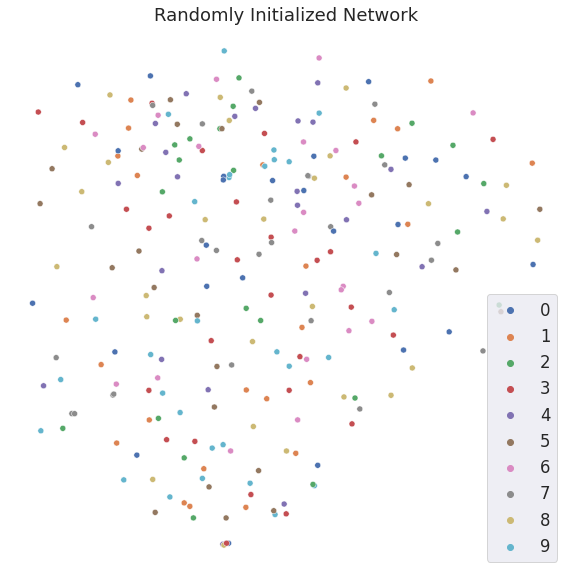

In [ ]:
# plot t-SNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

def plot_vecs_n_labels(v,labels):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(x= v[:,0], y= v[:,1], legend='full', hue=labels, hue_order=['0','1','2','3','4','5','6','7','8','9'] ).set(title='Randomly Initialized Network')
sns.set(font_scale=1.5)
for batch_idx, (images, targets) in enumerate(trainloader):
    print(batch_idx)
    images[0], images[1], targets = images[0].to(device),images[1].to(device), targets.to(device)
    labels = targets.cpu().numpy().astype('str')
    h_i, h_j, z_i, z_j = net(images[0], images[1])
    y_tsne = tsne.fit_transform(z_i.cpu().data)
    plot_vecs_n_labels(y_tsne,labels)
    break



In [ ]:
#Load the pre-trained model parameters
paramsend_save_name = 'paramsend_bs_restart.pt'
path_paramsend = "/content/gdrive/MyDrive/paramsend_bs_restart.pt"
checkpoint = torch.load(path_paramsend)
loss= checkpoint['loss']
epoch = checkpoint['epoch']
start_epoch=epoch+1
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [ ]:
start_epoch

376

0


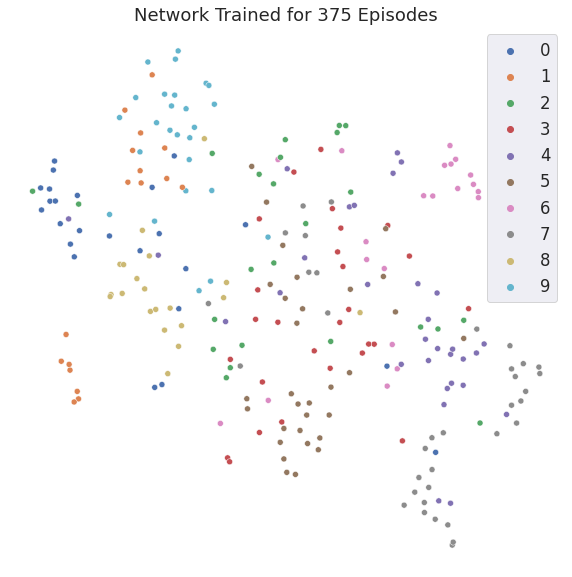

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

def plot_vecs_n_labels(v,labels):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(x= v[:,0], y= v[:,1], legend='full', hue=labels, hue_order=['0','1','2','3','4','5','6','7','8','9'] ).set(title='Network Trained for 375 Episodes')
sns.set(font_scale=1.5)
for batch_idx, (images, targets) in enumerate(trainloader):
    print(batch_idx)
    images[0], images[1], targets = images[0].to(device),images[1].to(device), targets.to(device)
    labels = targets.cpu().numpy().astype('str')
    h_i, h_j, z_i, z_j = net(images[0], images[1])
    y_tsne = tsne.fit_transform(z_i.cpu().data)
    plot_vecs_n_labels(y_tsne,labels)
    break

In [ ]:
#Load the pre-trained model parameters
paramsend_save_name = 'paramsend_bs_restart.pt'
path_paramsend = "/content/gdrive/MyDrive/paramsend_bs_restart_r.pt"
checkpoint = torch.load(path_paramsend)
loss= checkpoint['loss']
epoch = checkpoint['epoch']
start_epoch=epoch+1
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [ ]:
start_epoch

501

0


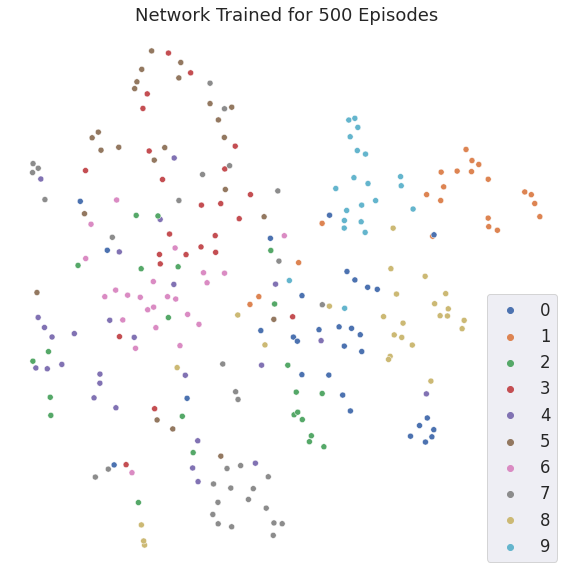

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

def plot_vecs_n_labels(v,labels):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(x= v[:,0], y= v[:,1], legend='full', hue=labels, hue_order=['0','1','2','3','4','5','6','7','8','9'] ).set(title='Network Trained for 500 Episodes')
sns.set(font_scale=1.5)
for batch_idx, (images, targets) in enumerate(trainloader):
    print(batch_idx)
    images[0], images[1], targets = images[0].to(device),images[1].to(device), targets.to(device)
    labels = targets.cpu().numpy().astype('str')
    h_i, h_j, z_i, z_j = net(images[0], images[1])
    y_tsne = tsne.fit_transform(z_i.cpu().data)
    plot_vecs_n_labels(y_tsne,labels)
    break